In [151]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import roc_curve, auc
import sklearn as sk

train = pd.read_csv('../training_data/training_set.csv')
val = pd.read_csv('../safe_data/safe_data.csv')
locations = train['Location'].unique()

In [152]:
# convert to binary
def format_data(data):
    
    data["RainTomorrow"].replace(('Yes', 'No'), (1, 0), inplace=True)
    data["RainToday"].replace(('Yes', 'No'), (1, 0), inplace=True)
    data.drop(columns=['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM'], inplace=True)

    # convert direction strings to degrees
    data['WindGustDir'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True
    )

    data['WindDir9am'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True
    )

    data['WindDir3pm'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
        inplace=True
    )
    
    data.dropna(
        axis=0, how='any',
        subset=['WindGustDir','WindDir9am','WindDir3pm','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'],
        inplace=True
    )

    data.dropna(axis=0, how='any', inplace=True)
    
    data_date = pd.to_datetime(data.pop('Date'))
    
    wv = data.pop('WindGustSpeed')
    wd = data.pop('WindGustDir')*np.pi/180
    data['WindGustX'] = wv*np.cos(wd)
    data['WindGustY'] = wv*np.sin(wd)

    wv = data.pop('WindSpeed9am')
    wd = data.pop('WindDir9am')*np.pi/180
    data['Wind9amX'] = wv*np.cos(wd)
    data['Wind9amY'] = wv*np.sin(wd)

    wv = data.pop('WindSpeed3pm')
    wd = data.pop('WindDir3pm')*np.pi/180
    data['Wind3pmX'] = wv*np.cos(wd)
    data['Wind3pmY'] = wv*np.sin(wd)
    
    timestamp_s = data_date.map(datetime.datetime.timestamp)
    day = 24*60*60
    year = (365.2425)*day
#     data['daysin'] = np.sin(timestamp_s * (2 * np.pi/day))
#     data['daycos'] = np.cos(timestamp_s * (2 * np.pi/day))
    data['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
    data['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))
    
    return data


In [153]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None, batch_size=32):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='RainTomorrow', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        predictions = 0
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [154]:
from sklearn.metrics import confusion_matrix, f1_score
def visual_cm(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred,labels = [1,0])
    group_names = ['TP','FN','FP','TN']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = [1,0], yticklabels = ['Rain','No Rain'])
    
    sensitivity = "{0:.2%}".format(cm[0,0]/(cm[0,0]+cm[0,1]))
    specificity = "{0:.2%}".format(cm[1,1]/(cm[1,0]+cm[1,1]))
    print("Sensitivity(ability to detect rain in rainy days):", sensitivity)
    print("Specificity(ability to detect Not rain in normal days):",specificity)
    print("f1 score:", f1_score(y_train, y_pred))

In [159]:
def make_model(uid):
#     lstm_model = tf.keras.models.Sequential([
#         tf.keras.layers.LSTM(16, return_sequences=True, name=f'{uid}16'),
#         tf.keras.layers.LSTM(32, return_sequences=True, name=f'{uid}32'),
#         tf.keras.layers.LSTM(64, return_sequences=True, name=f'{uid}64'),
#         tf.keras.layers.Dense(units=1, activation='sigmoid', name=f'{uid}dense')
#     ], name = uid)
    
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=False)),
        tf.keras.layers.Dense(units=1, activation='sigmoid'),    
    ])
    return lstm_model

lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=False)),
    tf.keras.layers.LSTM(4, return_sequences=False),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),    
])
loss = {}
val_loss = {}
acc = {}
val_acc = {}

epochs = 2
lr=0.00001
batch_size = 32

def compile_and_fit(model, window, lr=lr, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(lr=lr),
        metrics=[tf.metrics.BinaryAccuracy()])
    
    history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping], verbose=2)
    return (history, model)

In [156]:
# locations
# train[train['Location'] == 'Albury']

In [160]:
# l='Albury'
# loc_data = train.copy(deep=True).loc[train['Location'] == l]
loc_data = train.copy(deep=True)
loc_data = format_data(loc_data)

print(loc_data['RainTomorrow'].value_counts())

n = len(loc_data)
train_df = loc_data
val_df = loc_data[int(n*0.8):]   
test_df = loc_data
cols_to_norm = list(loc_data.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = train_df[cols_to_norm].mean()
train_std = train_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std

w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])
history, model = compile_and_fit(lstm_model, w, lr=lr)

0    68023
1    19064
Name: RainTomorrow, dtype: int64


/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Epoch 1/2
2722/2722 - 23s - loss: 0.6850 - binary_accuracy: 0.7776 - val_loss: 0.7796 - val_binary_accuracy: 0.3543
Epoch 2/2
2722/2722 - 21s - loss: 0.6647 - binary_accuracy: 0.7811 - val_loss: 0.7731 - val_binary_accuracy: 0.3634


In [163]:
e_val = val.copy(deep=True)
e_val = format_data(e_val)
val_df = e_val

train_df = e_train
val_df = e_val
test_df = e_train

cols_to_norm = list(e_val.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = val_df[cols_to_norm].mean()
train_std = val_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std

w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])

preds = lstm_model.predict(w.val)
count = 0
ytrue = np.array(val_df[7:]['RainTomorrow'])

preds = preds.reshape(preds.shape[0])


fpr, tpr, thresholds = sk.metrics.roc_curve(ytrue, preds)
roc_auc = sk.metrics.auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc_metrics = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

preds = np.array([(x>0.5).astype("int32") for x in preds])
# preds = np.array([(x>roc_metrics['thresholds'].values).astype("int32") for x in preds])

print(pd.DataFrame(preds)[0].value_counts())
print(preds.shape)
print(ytrue.shape)


for i in range(0,preds.shape[0]):
    if ((preds[i]-ytrue[i])**2) == 0:
        count+=1
print(count/preds.shape[0])

visual_cm(ytrue, preds)

Area under the ROC curve : 0.504478
0.459875    2
0.593830    2
0.450605    2
0.542035    2
0.539012    2
           ..
0.489503    1
0.541510    1
0.395756    1
0.541513    1
0.500001    1
Name: 0, Length: 25788, dtype: int64
(25831,)
(25831,)
0.0


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [139]:
locs = list()
for l in locations:
    print(l)
    loc_data = train.copy(deep=True).loc[train['Location'] == l]
    
    loc_data = format_data(loc_data)
    
    if (loc_data.shape[0] == 0): continue
        
    locs.append(l)
    
    n = len(loc_data)
    train_df = loc_data
    val_df = loc_data    
    test_df = loc_data
    cols_to_norm = list(loc_data.columns)
    cols_to_norm.remove('RainToday')
    cols_to_norm.remove('RainTomorrow')

    train_mean = train_df[cols_to_norm].mean()
    train_std = train_df[cols_to_norm].std()

    train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
    val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
    test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=False)),
        tf.keras.layers.Dense(units=1, activation='sigmoid'),    
    ])
    
    w = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])
    history, model = compile_and_fit(lstm_model, w, lr=lr)
    
    fname = rf'models_noday/model_{l}.h5'
    model.save(fname)

    loss[l] = history.history['loss']
    val_loss[l] = history.history['val_loss']
    acc[l] = history.history['binary_accuracy']
    val_acc[l] = history.history['val_binary_accuracy']

Albury
Epoch 1/10
59/59 - 2s - loss: 0.6594 - binary_accuracy: 0.7856 - val_loss: 0.6592 - val_binary_accuracy: 0.7856
Epoch 2/10
59/59 - 1s - loss: 0.6589 - binary_accuracy: 0.7856 - val_loss: 0.6586 - val_binary_accuracy: 0.7856
Epoch 3/10
59/59 - 1s - loss: 0.6583 - binary_accuracy: 0.7856 - val_loss: 0.6580 - val_binary_accuracy: 0.7856
Epoch 4/10
59/59 - 1s - loss: 0.6577 - binary_accuracy: 0.7856 - val_loss: 0.6574 - val_binary_accuracy: 0.7856
Epoch 5/10
59/59 - 1s - loss: 0.6570 - binary_accuracy: 0.7856 - val_loss: 0.6567 - val_binary_accuracy: 0.7856
Epoch 6/10
59/59 - 1s - loss: 0.6563 - binary_accuracy: 0.7856 - val_loss: 0.6560 - val_binary_accuracy: 0.7856
Epoch 7/10
59/59 - 1s - loss: 0.6556 - binary_accuracy: 0.7856 - val_loss: 0.6552 - val_binary_accuracy: 0.7856
Epoch 8/10
59/59 - 1s - loss: 0.6548 - binary_accuracy: 0.7856 - val_loss: 0.6544 - val_binary_accuracy: 0.7856
Epoch 9/10
59/59 - 1s - loss: 0.6540 - binary_accuracy: 0.7856 - val_loss: 0.6536 - val_binary_ac

OSError: Unable to create file (unable to open file: name = 'models_noday/model_Albury.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [123]:
locs = list()
for l in locations:
    loc_data = train.copy(deep=True).loc[train['Location'] == l]
    
    loc_data = format_data(loc_data)
    
    if (loc_data.shape[0] == 0): continue
        
    locs.append(l)

Albury


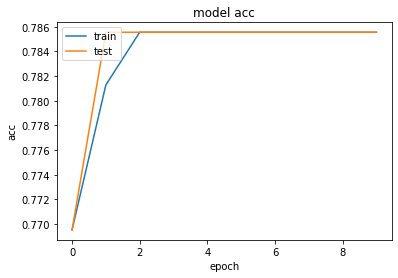

BadgerysCreek


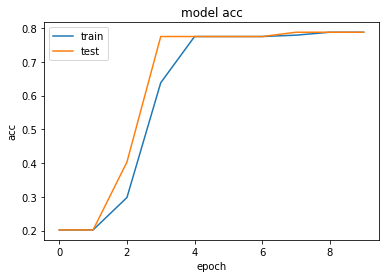

Cobar


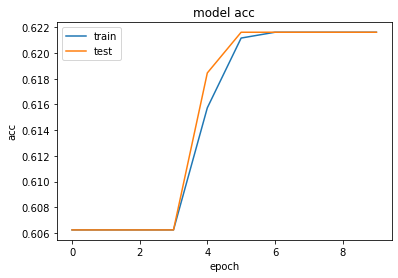

CoffsHarbour


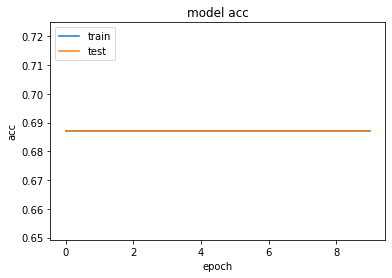

Moree


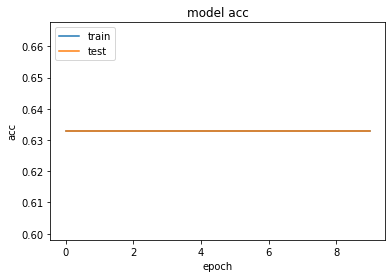

NorahHead


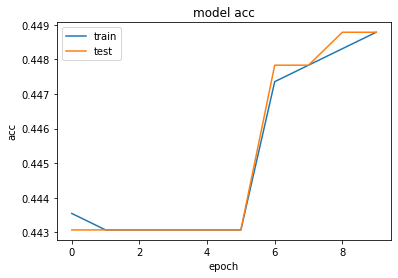

NorfolkIsland


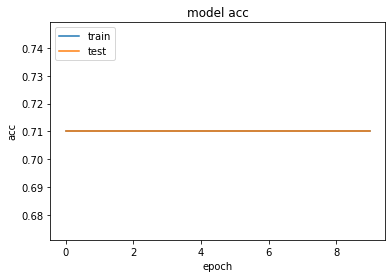

Richmond


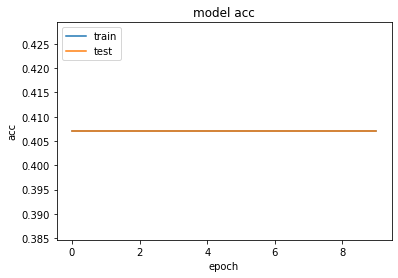

Sydney


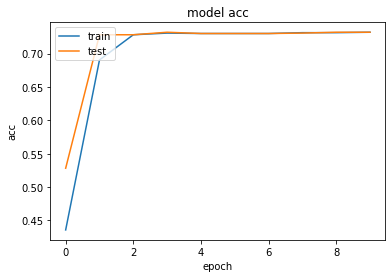

SydneyAirport


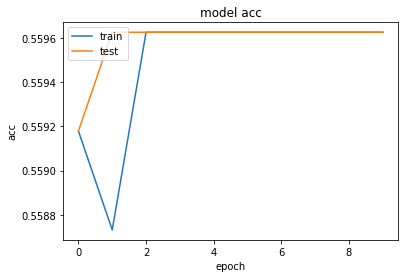

WaggaWagga


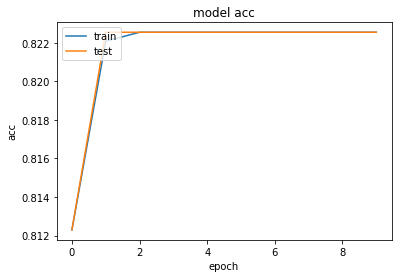

Williamtown


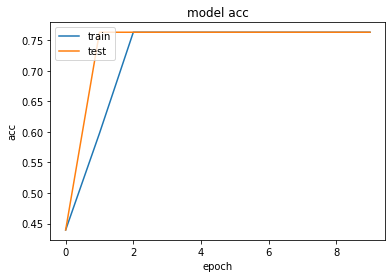

Wollongong


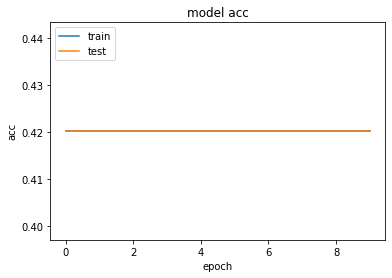

Canberra


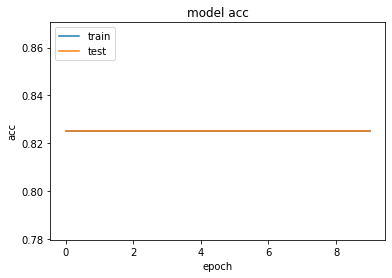

Tuggeranong


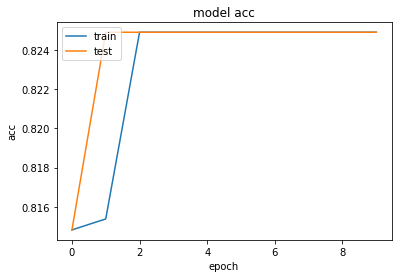

Ballarat


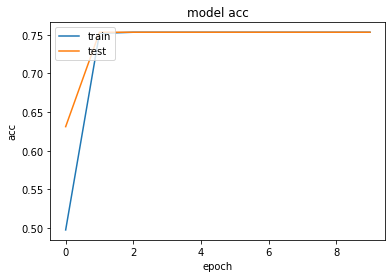

Bendigo


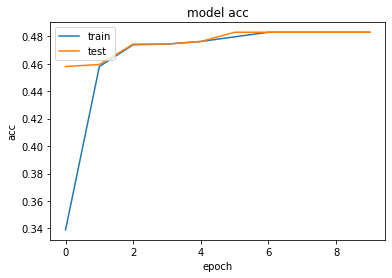

Sale


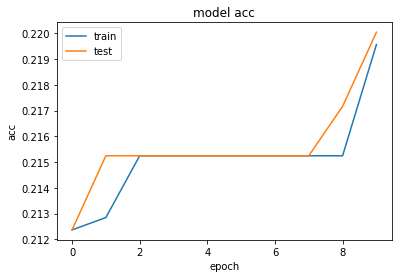

MelbourneAirport


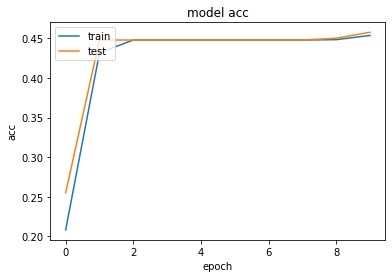

Melbourne


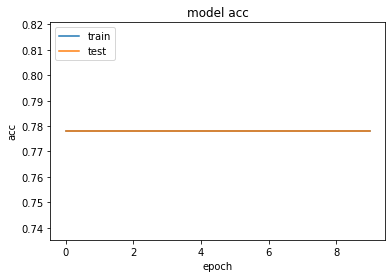

Mildura


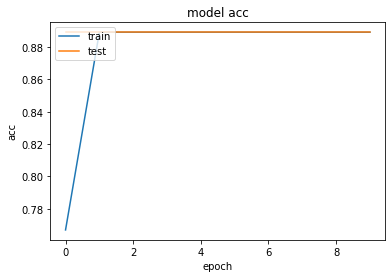

Nhil


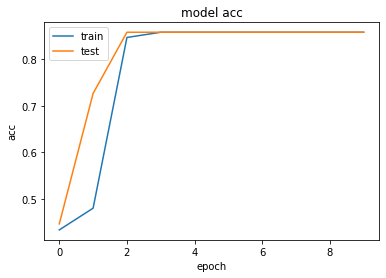

Portland


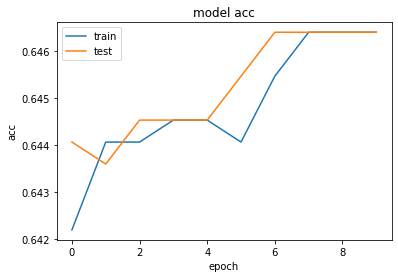

Watsonia


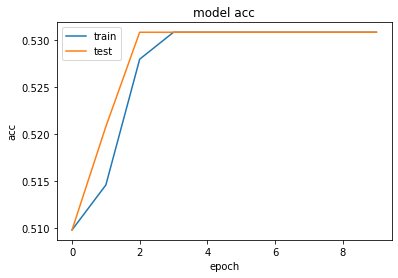

Dartmoor


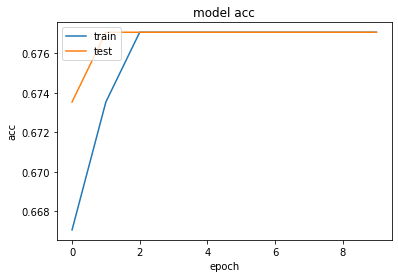

Brisbane


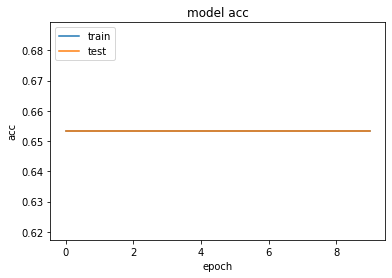

Cairns


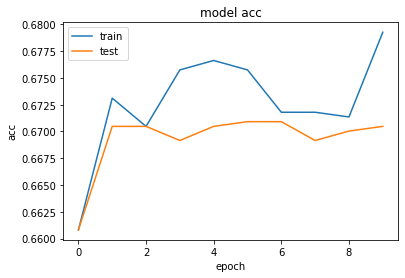

GoldCoast


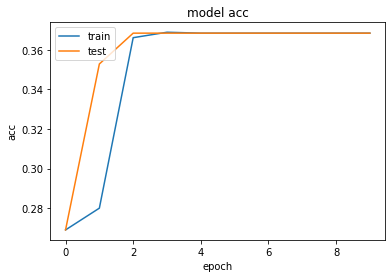

Townsville


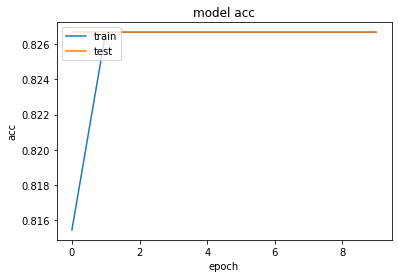

Adelaide


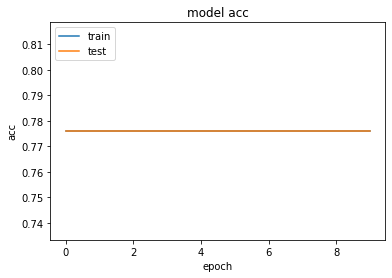

MountGambier


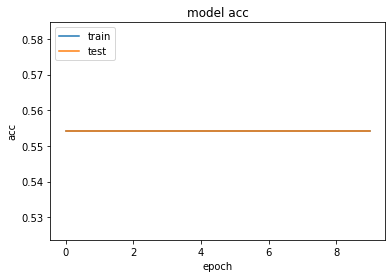

Nuriootpa


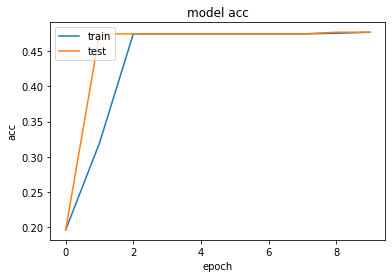

Woomera


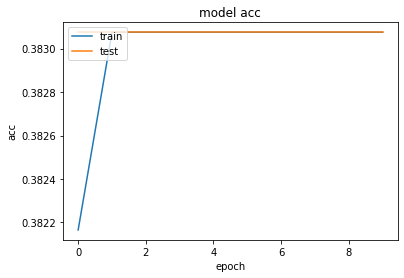

Witchcliffe


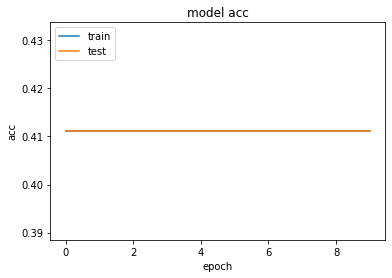

PearceRAAF


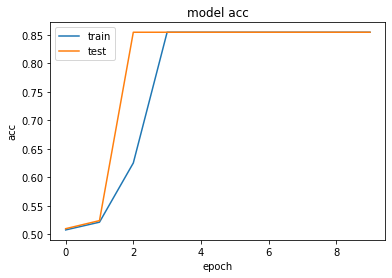

PerthAirport


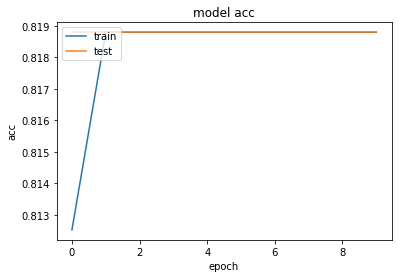

Perth


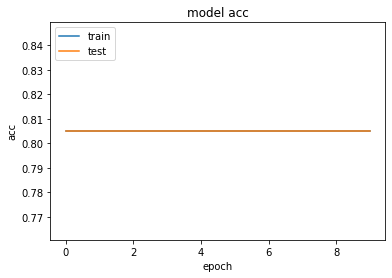

Walpole


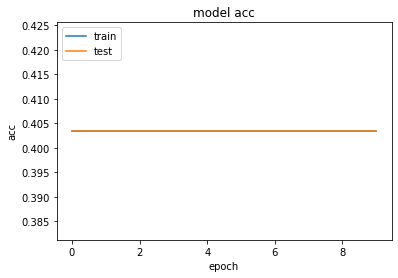

Hobart


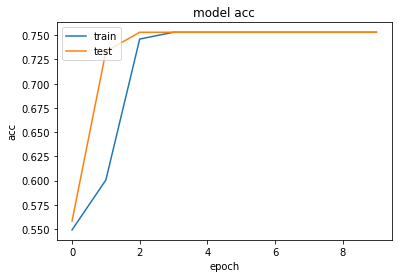

Launceston


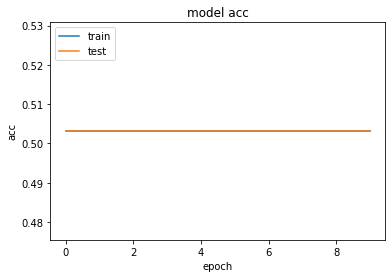

AliceSprings


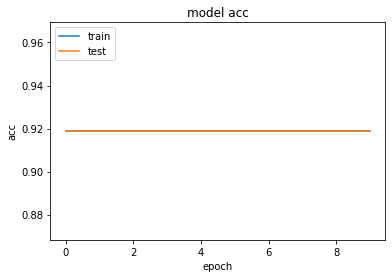

Darwin


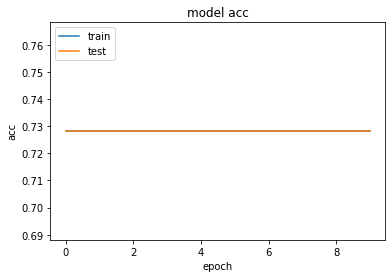

Katherine


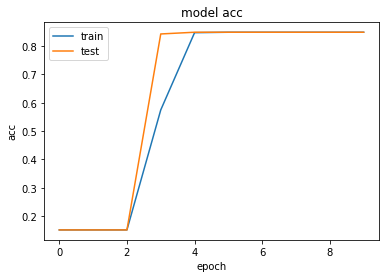

Uluru


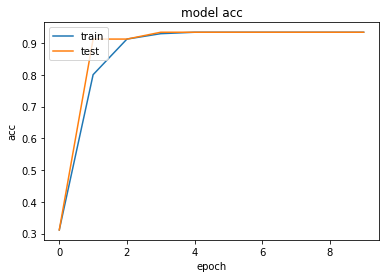

In [98]:
for l in locs:

#     plt.plot(loss[l])
#     plt.plot(val_loss[l])
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

    print(l)
    plt.plot(acc[l])
    plt.plot(val_acc[l])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [99]:
def load_all_models():
    all_models = list()
    for i in ['BadgerysCreek','Cobar','NorahHead', 'Bendigo', 'MelbourneAirport','Portland','Cairns','Uluru']:
        filename = rf'models/model_{i}.h5'
        model = keras.models.load_model(filename)
        all_models.append(model)
    return all_models

members = load_all_models()

In [100]:
e_train = train.copy(deep=True)
e_val = val.copy(deep=True)
e_train = format_data(e_train)
e_val = format_data(e_val)

n = len(e_train)
train_df = e_train
val_df = e_val
test_df = e_train[int(n*0.7):]

cols_to_norm = list(e_train.columns)
cols_to_norm.remove('RainToday')
cols_to_norm.remove('RainTomorrow')

train_mean = val_df[cols_to_norm].mean()
train_std = val_df[cols_to_norm].std()

train_df.loc[:,cols_to_norm] = (train_df.loc[:,cols_to_norm] - train_mean) / train_std
val_df.loc[:,cols_to_norm] = (val_df.loc[:,cols_to_norm] - train_mean) / train_std
test_df.loc[:,cols_to_norm] = (test_df.loc[:,cols_to_norm] - train_mean) / train_std
    
window = WindowGenerator(input_width=7, label_width=1, shift=1, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['RainTomorrow'])

/home/mqp/pyenv/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [101]:
yhats = [model.predict(window.val) for model in members]
yhats = np.array(yhats)

In [92]:
yhats.shape
preds.shape

(25831, 1)

0    14484
1    11347
Name: 0, dtype: int64
(25831,)
(25831,)
0.5330029809144051
Sensitivity(ability to detect rain in rainy days): 43.99%
Specificity(ability to detect Not rain in normal days): 56.09%
f1 score: 0.30275706606554537


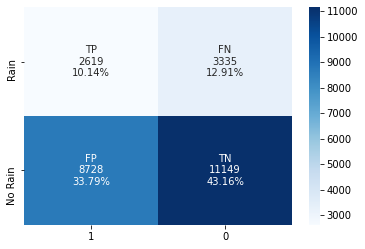

In [102]:
count = 0
ytrue = np.array(window.val_df[7:]['RainTomorrow'])

preds = np.mean(yhats, axis=0)
preds = preds.reshape(preds.shape[0])
preds = np.array([(x>0.5).astype("int32") for x in preds])

print(pd.DataFrame(preds)[0].value_counts())
print(preds.shape)
print(ytrue.shape)


for i in range(0,preds.shape[0]):
    if ((preds[i]-ytrue[i])**2) == 0:
        count+=1
print(count/preds.shape[0])

visual_cm(ytrue, preds)

Area under the ROC curve : 0.500011
           fpr       tpr     1-fpr        tf  thresholds
4202  0.496982  0.503275  0.503018  0.000257    0.496602


Text(0.5, 1.0, 'Receiver operating characteristic')

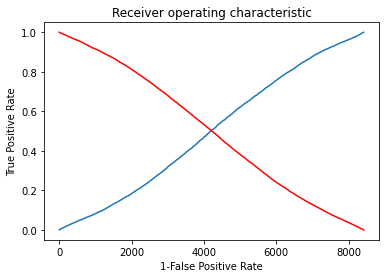

In [110]:
yhats_mean = np.mean(yhats, axis=0)
yhats_mean = yhats_mean.reshape(yhats_mean.shape[0])
ytrue = np.array(val_df[1:]['RainTomorrow'])

# Following ROC code from:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
fpr, tpr, threshold = sk.metrics.roc_curve(ytrue, yhats_mean)
roc_auc = sk.metrics.auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc_metrics = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
print(roc_metrics)

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
# ax.set_xticklabels([])

In [115]:
yhats_mean = np.mean(yhats, axis=0)
yhats_mean = yhats_mean.reshape(yhats_mean.shape[0])
yhats_mean = np.array([(x>roc_metrics['thresholds'].values).astype("int32") for x in yhats_mean])
print(pd.DataFrame(yhats_mean).value_counts())

0    12967
1    12870
dtype: int64


In [81]:
yhats_mean = np.mean(yhats, axis=0)
print(yhats_mean[0])
# print(np.where(yhats_mean>0.5))

# yhats_mean = np.mean(yhats_mean, axis=1)
# print(yhats_mean[0])
yhats_mean = yhats_mean.reshape(yhats_mean.shape[0])
print(yhats_mean[0])
# yhats_mean = np.array([(x>0.496602).astype("int32") for x in yhats_mean])

print(pd.DataFrame(yhats_mean).value_counts())
# ytrue = np.array(val_df[1:]['RainTomorrow'])

[[0.4965742]]
0.4965742
0    12923
1    12914
dtype: int64


In [116]:
count = 0
# ytrue = np.array(val_df[1:]['RainTomorrow'])
print(ytrue[:10])
print(yhats_mean[:10])
print(pd.DataFrame(yhats_mean)[0].value_counts())

for i in range(0,yhats_mean.shape[0]):
    if ((yhats_mean[i]-ytrue[i])**2) == 0:
        count+=1
print(count/yhats_mean.shape[0])

# count=0
# ytrue = np.array(val_df[:val_df.shape[0]-1]['RainTomorrow'])
# print(ytrue[:10])

# for i in range(0,yhats_mean.shape[0]):
#     if ((yhats_mean[i]-ytrue[i])**2) == 0:
#         count+=1
# print(count/yhats_mean.shape[0])

[0 0 0 0 0 1 1 0 0 1]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]]
0    12967
1    12870
Name: 0, dtype: int64
0.5033092077253551
